This example show how to read an ODV netCDF file that stored data as profiles in Python.      
The file has been obtained using the [`webODV`](https://emodnet-chemistry.webodv.awi.de/) tool.    

Change the variable:
- varname
- datadir
- datafile
in order to get this example working with your data.

__Notes:__ this code is a simplification of the more complete code [`NCODV`](https://github.com/gher-ulg/DIVAnd.jl/blob/master/src/NCODV.jl) (written in Julia), which takes into account more complex situations. For instance here we don't read the quality flags.

In [1]:
import os
import netCDF4
import logging
import numpy as np
import matplotlib.pyplot as plt
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Start")

INFO:root:Start


If you want to make a test with the same file, you can download it from https://dox.ulg.ac.be/index.php/s/ajLsZ49m27TGI19/download

In [2]:
varname = "Water body silicate"
datadir = "/data/EMODnet/"
datafile = os.path.join(datadir, "eutrophication_Mediterranean_Eutrophication_Med_profiles_2021_c5tIYftd.nc")

## File reading

In [3]:
# Open the netCDF file
with netCDF4.Dataset(datafile, "r") as nc:
    
    # Get the dimensions: number of stations and number of samples
    nstations = int(nc.dimensions["N_STATIONS"].size)
    ndepths = int(nc.dimensions["N_SAMPLES"].size)
    logger.info(f"Working on {nstations} stations")
    
    # Allocate empty vectors before filling them
    obslon = np.empty(nstations * ndepths)
    obslat = np.empty(nstations * ndepths)
    obsval = np.empty(nstations * ndepths)
    obsdepth = np.empty(nstations * ndepths)
    obstime = np.empty_like(obsdepth)
    
    # Read coordinates
    obsproflon = nc.get_variables_by_attributes(standard_name="longitude")[0][:]
    obsproflat = nc.get_variables_by_attributes(standard_name="latitude")[0][:]
    obsproftime = nc.get_variables_by_attributes(standard_name="time")[0][:]
    ncvar_z = nc.get_variables_by_attributes(long_name="Depth")[0][:]

    try:
        ncvar = nc.get_variables_by_attributes(long_name=varname)[0][:]
    except IndexError:
        logger.warning(f"Cannot find a variable named {varname}")
    
    # Loop on the stations 
    istart = 0
    for ii in range(0, nstations):
        
        # Load the variable profile
        profilevar = ncvar[ii,:]
        
        # Extract only the good values 
        # (i.e. those which are not masked)
        goodvalues = np.where(profilevar.mask == False)[0]
        
        # Count number of good values
        ngood = len(goodvalues)
        
        # Fill the vectors
        iend = istart + ngood 
        obslon[istart:iend] = obsproflon[ii] * np.ones(ngood)
        obslat[istart:iend] = obsproflat[ii] * np.ones(ngood)
        obstime[istart:iend] = obsproftime[ii] * np.ones(ngood)
        obsdepth[istart:iend] = ncvar_z[ii, goodvalues]
        obsval[istart:iend] = ncvar[ii, goodvalues]
        istart = iend
        
    # Take only the good part of the vectors
    obslon = obslon[0:iend]
    obslat = obslat[0:iend]
    obstime = obstime[0:iend]
    obsdepth = obsdepth[0:iend]
    obsval = obsval[0:iend]
    
logger.info(f"Final size of the vectors: {iend}")

INFO:root:Working on 2303 stations
INFO:root:Final size of the vectors: 23838


## Plot to check the station positions

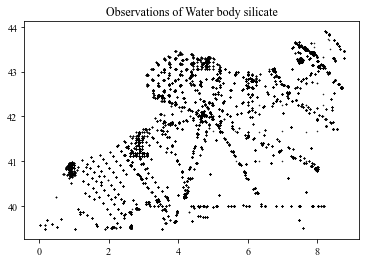

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(obslon, obslat, "ko", markersize=.5)
ax.set_title(f"Observations of {varname}")
plt.show()